[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/stammler/dustpy/HEAD?labpath=examples%2Fexample_planetesimal_formation.ipynb)

# Example: Planetesimal Formation

This example demonstrates how to add planetesimal formation into `DustPy` models. We follow [Stammler et al. (2019)](https://doi.org/10.3847/2041-8213/ab4423) that showed that planetesimal formation could explain the optical depths observed in dust rings of protoplanetary disks.

The method is described in detail in [Schoonenberg et al. (2018)](https://doi.org/10.1051/0004-6361/201834047). Planetesimal formation is triggered as soon as the midplane dust-to-gas ratio exceeds a critical threshold (typically of the order unity). If this threshold value is exceeded a fraction $\large \zeta$ of the dust mass per settling time scale of each mass bin $i$ is converted into planetesimals. $\large \zeta$ is assumed to be $0.1$.

$\Large R^i = \frac{\partial}{\partial t} \Sigma_\mathrm{d}^i = -\frac{\Sigma_\mathrm{d}^i}{t_\mathrm{sett}^i} = -\zeta\,\Sigma_\mathrm{dust}^i\,\mathrm{St}^i\,\Omega_\mathrm{K}$.

The negative sum of these rates over all dust species is then the mass that has to be added to the planetesimal surface density.

$\Large \frac{\partial}{\partial t} \Sigma_\mathrm{plan} = -\sum\limits_i R^i$.

Since planetesimal formation requires high midplane dust-to-gas ratios which are typically not reached in smooth disks, we have to add a gap to our gas surface density profile. The outer edge of the gap can then trap particles increasing the midplane dust-to-gas ratio. Following [Dullemond et al. (2018)](https://doi.org/10.3847/2041-8213/aaf742) we use the gap profile given by

$\Large F = \exp \left[ -A\,\exp\left( -\frac{\left( r - r_0\right)^2}{2w^2} \right) \right]$,

with a gap amplitude $A$, a gap location $r_0$, and a gap width $w$. This gap profile can be achievend by either adding a torque profile as described in an earlier example about planetary gaps or by increasing the viscosity by the same factor

$\Large \alpha = \frac{\alpha_0}{F}$.

In addition to that we increase the fragmentation velocity to $10\,\mathrm{m/s}$, since larger particles settle easier to the midplane and contribute more to planetesimal formation. Similar effects can be achieved by reducing the viscous $\alpha$ parameter. But then the overall evolution would be slower.

We furthermore increase the critical cut-off radius of the disk to increase the mass reservoir in the outer disk. And we increase the initial disk mass compared to the default model.

But first we define our model parameters, such that they can be changed later easily.

In [1]:
from dustpy import Simulation
import dustpy.constants as c

In [2]:
# Viscous alpha parameter
alpha0 = 1.e-3
# Fragmentation velocity [cm/s]
vfrag = 1000.

# Critical disk cut-off radius [cm]
Rc = 60. * c.au
# Disk mass
Mdisk = 0.1 * c.M_sun

# Gap location [cm]
r0 = 10. * c.au
# Gap width [cm]
w = 2. * c.au
# Gap amplitude
A = 2.

# Critical dust-to-gas ratio
d2g_crit = 1.
# Planetesimal formation efficiency
zeta = 0.1

Before `Simulation.initialize()` we set our desired parameters in the `Simulation.ini` object.  
Note that we have to increase the maximum particle mass due to the high fragmentation velocity.

In [3]:
sim = Simulation()
sim.ini.gas.alpha = alpha0
sim.ini.gas.SigmaRc = Rc
sim.ini.gas.Mdisk = Mdisk
sim.ini.dust.vFrag = vfrag
sim.ini.grid.mmax = 1.e8

## Refining the radial grid

In this model we want to increase the radial resolution around the outer gap edge. We use the same method of refining the radial grid as described in earlier examples.

In [4]:
import numpy as np

def refinegrid(ri, r0, num=3):
    """Function to refine the radial grid

    Parameters
    ----------
    ri : array
        Radial grid
    r0 : float
        Radial location around which grid should be refined
    num : int, option, default : 3
        Number of refinement iterations

    Returns
    -------
    ri : array
        New refined radial grid"""
    if num == 0:
        return ri
    ind = np.argmin(r0 > ri) - 1
    indl = ind-num
    indr = ind+num+1
    ril = ri[:indl]
    rir = ri[indr:]
    N = (2*num+1)*2
    rim = np.empty(N)
    for i in range(0, N, 2):
        j = ind-num+int(i/2)
        rim[i] = ri[j]
        rim[i+1] = 0.5*(ri[j]+ri[j+1])
    ri = np.concatenate((ril, rim, rir))
    return refinegrid(ri, r0, num=num-1)

Here the refinement is centered on the outer edge of the gap, where the dust accumulated instead of the gap center.

In [5]:
ri = np.geomspace(1.e0, 1.e3, 100) * c.au
sim.grid.ri = refinegrid(ri, r0+3.*w)

In [6]:
sim.initialize()

We furthermore let the simulation run until $1\,\mathrm{Myr}$ to see an effect in the planetesimals.

In [7]:
sim.t.snapshots = np.hstack(
    [sim.t, np.geomspace(1.e3, 1.e6, 31) * c.year]
)

## Adding gap

As describe earlier we want to add a gap by changing the $\alpha$ profile. We simply set the new $\alpha$ values. Since it is constant in the default model, we do not need to set an updater.

In [8]:
F = np.exp(-A * np.exp(-0.5 * (sim.grid.r - r0)**2 / w**2) )
sim.gas.alpha = alpha0 / F

## Adding planetesimals

We add a new group for the planetesimals which contains the planetesimal surface density and the total planetesimal mass in our model. We initialize the field with zeros.

In [9]:
sim.addgroup("planetesimals", description="Planetesimal quantities")

In [10]:
sim.planetesimals.addfield("M", 0., description="Total planetesimal mass [g]")
sim.planetesimals.addfield("Sigma", np.zeros_like(sim.gas.Sigma), description="Planetesimal surface density [g/cm²]")

In [11]:
sim.planetesimals

Group (Planetesimal quantities)
-------------------------------
    M            : Field (Total planetesimal mass [g])
    Sigma        : Field (Planetesimal surface density [g/cm²])
  -----

We firthermore have to write an updater that is calculating the total planetesimal mass from the planetesimal surface densities. We assign this function to the updater of the field.

In [12]:
def M_plan(sim):
    return (sim.grid.A * sim.planetesimals.Sigma[:]).sum()

In [13]:
sim.planetesimals.M.updater.updater = M_plan

We have to create an updater for the planetesimal group, in which we update the total mass of planetesimals, and we have to add the planetesimal group to the updater of the simulation object.

In [14]:
sim.planetesimals.updater = ["M"]
sim.updater = ["star", "grid", "gas", "dust", "planetesimals"]

## Adding planetesimal formation

To add planetesimal formation we calculate for each particle species at each radius if it contributes to planetesimal formation. These values are negative external source terms for dust evolution, since we remove dust mass and convert them into planetesimals. We therefore add them as updater to the external dust sources.

In [15]:
def S_ext(sim):
    # Midplane dust-to-gas ratio
    d2g_mid = sim.dust.rho.sum(-1) / sim.gas.rho
    
    # Mask that defines if planetesimal formation is triggered
    mask = np.where(d2g_mid >= d2g_crit, True, False)
    
    # Change in dust surface densities
    ret = np.where(mask[:, None], -zeta*sim.dust.Sigma * sim.dust.St * sim.grid.OmegaK[:, None], 0.)
    # Set to zero at boundaries
    ret[0, :] = 0.
    ret[-1, :] = 0.
    
    return ret

In [16]:
sim.dust.S.ext.updater.updater = S_ext

Similarly, the negative sum over all external source terms is our planetesimal formation rate. We can therefore write a source term function which we can add as derivative to the planetesimal surface density for integration.

In [17]:
def dSigmaPlan(sim, x, Y):
    return -sim.dust.S.ext.sum(-1)

In [18]:
sim.planetesimals.Sigma.differentiator = dSigmaPlan

We now have to create an integration instruction and add it to the `DustPy` integrator.

In [19]:
from simframe import Instruction
from simframe import schemes

We use an explicit 1st-order Euler scheme...

In [20]:
inst_planetesimals = Instruction(
    schemes.expl_1_euler,
    sim.planetesimals.Sigma,
    description="Planetesimals: explicit 1st-order Euler method")

...and append this instruction to the instruction set of the integrator.

In [21]:
sim.integrator.instructions.append(inst_planetesimals)

The integrator has now a new instruction for the planetesimal surface density.

In [22]:
sim.integrator.instructions

[Instruction (Dust: implicit 1st-order direct solver),
 Instruction (Gas: implicit 1st-order direct solver),
 Instruction (Planetesimals: explicit 1st-order Euler method)]

We do not need to change the time step function, since the default function already includes the external dust source terms.

Before we run the simulation we update the entire simulation object and change the name of the data directory.

In [23]:
sim.update()
sim.writer.datadir = "example_planetesimal_formation"

In [24]:
sim.run()


DustPy v1.0.8

Documentation: https://stammler.github.io/dustpy/
PyPI:          https://pypi.org/project/dustpy/
GitHub:        https://github.com/stammler/dustpy/

Please cite Stammler & Birnstiel (2022).

Checking for mass conservation...

    - Sticking:
        max. rel. error:  2.81e-14
        for particle collision
            m[114] =  1.93e+04 g    with
            m[116] =  3.73e+04 g
    - Full fragmentation:
        max. rel. error:  6.66e-16
        for particle collision
            m[90] =  7.20e+00 g    with
            m[95] =  3.73e+01 g
    - Erosion:
        max. rel. error:  1.78e-15
        for particle collision
            m[110] =  5.18e+03 g    with
            m[118] =  7.20e+04 g

Creating data directory example_planetesimal_formation.
Writing file example_planetesimal_formation/data0000.hdf5
Writing dump file example_planetesimal_formation/frame.dmp
Writing file example_planetesimal_formation/data0001.hdf5
Writing dump file example_planetesimal_formation/f

We can plot our results now.

In [25]:
from dustpy import plot

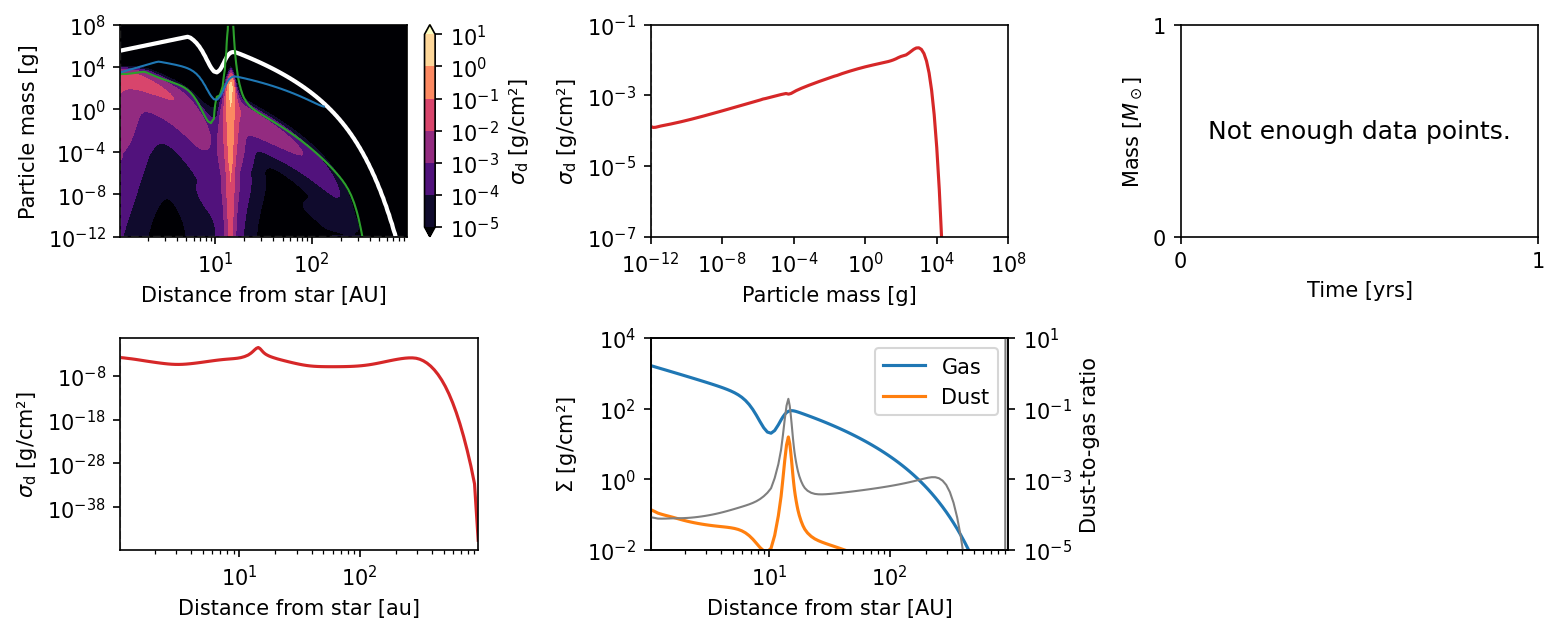

In [26]:
plot.panel(sim)

To check on planetesimal formation we extract the planetesimal parameters. Furthermore, we look at the total gas and dust masses.

In [27]:
SigmaGas = sim.writer.read.sequence("gas.Sigma")
SigmaDust = sim.writer.read.sequence("dust.Sigma")
Mplan = sim.writer.read.sequence("planetesimals.M")
t = sim.writer.read.sequence("t")

Calculation of total gas and dust masses.

In [28]:
Mgas = (sim.grid.A * SigmaGas).sum(-1)
Mdust = (sim.grid.A * SigmaDust.sum(-1)).sum(-1)

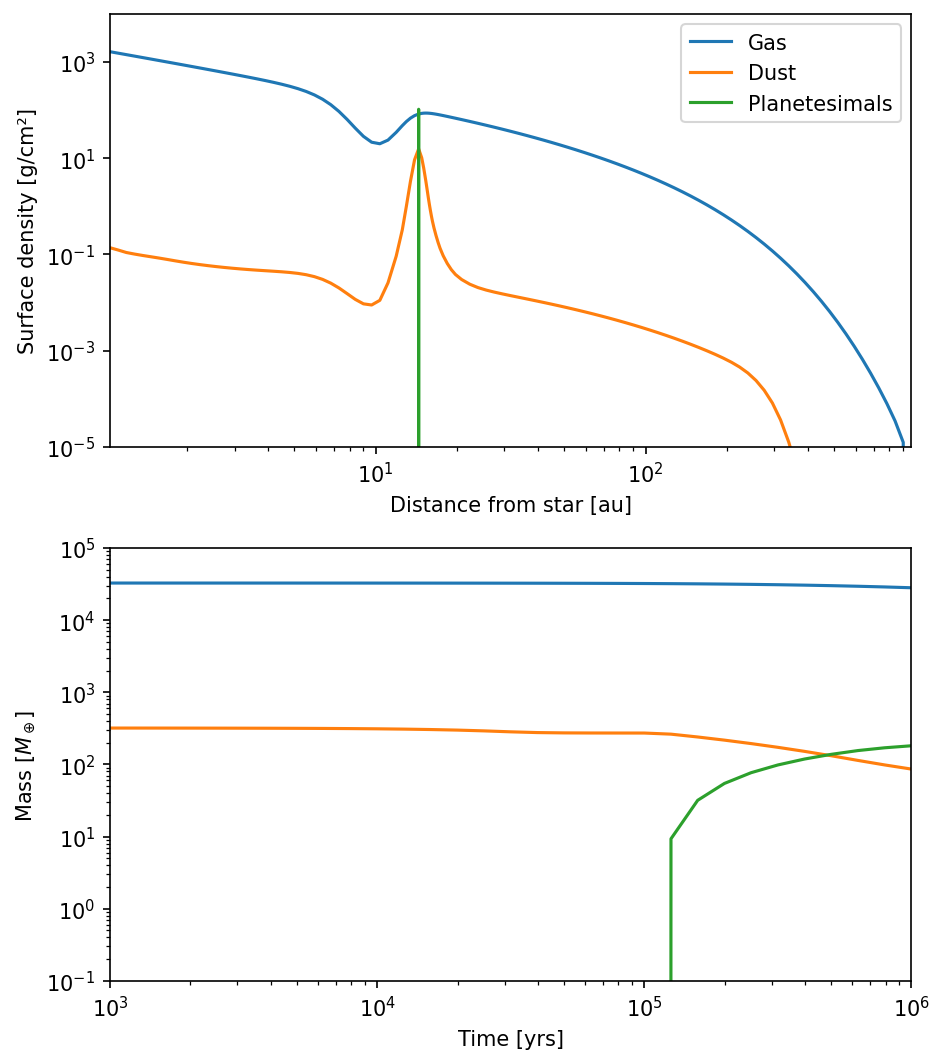

In [29]:
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150.

fig, ax = plt.subplots(nrows=2, figsize=(6.4, 7.2))

ax[0].loglog(sim.grid.r/c.au, sim.gas.Sigma, label="Gas")
ax[0].loglog(sim.grid.r/c.au, sim.dust.Sigma.sum(-1), label="Dust")
ax[0].loglog(sim.grid.r/c.au, sim.planetesimals.Sigma, label="Planetesimals")
ax[0].set_xlim(sim.grid.r[0]/c.au, sim.grid.r[-1]/c.au)
ax[0].set_ylim(1.e-5, 1.e4)
ax[0].set_xlabel("Distance from star [au]")
ax[0].set_ylabel("Surface density [g/cm²]")
ax[0].legend()

ax[1].loglog(t/c.year, Mgas/c.M_earth, label="Gas")
ax[1].loglog(t/c.year, Mdust/c.M_earth, label="Dust")
ax[1].loglog(t/c.year, Mplan/c.M_earth, label="Planetesimals")
ax[1].set_xlim(t[1]/c.year, t[-1]/c.year)
ax[1].set_ylim(1.e-1, 1.e5)
ax[1].set_xlabel(r"Time [yrs]")
ax[1].set_ylabel(r"Mass [$M_\oplus$]")

fig.set_layout_engine("tight")